In [1]:
import pickle
import pandas as pd
import urllib.request
import os
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

data_url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"

# download data
if not os.path.isfile("data.csv"):
    urllib.request.urlretrieve(data_url, "data.csv")

"""
Use the store_object function to make local caching of the data.
"""
def store_object(filename, instruction):
    # check if file was cached before and read it
    if os.path.isfile(filename):
        return pickle.load(open(filename, 'rb'))
    # run instruction and save it as pickle then return object
    else:
        obj = instruction()
        pickle.dump(obj, open(filename, 'wb'))
        return obj
    
data = store_object("data.pkl", lambda: pd.read_csv("data.csv"))
data = data[["Crm Cd", "Mocodes", "Crm Cd Desc"]]
data.head(5)

,Crm Cd,Mocodes,Crm Cd Desc
0,510,NaN,VEHICLE - STOLEN
1,330,1822 1402 0344,BURGLARY FROM VEHICLE
2,480,0344 1251,BIKE - STOLEN
3,343,0325 1501,SHOPLIFTING-GRAND THEFT ($950.01 & OVER)
4,354,1822 1501 0930 2004,THEFT OF IDENTITY


In [2]:
# 20 most common crimes
most_comma_crimes = data["Crm Cd"].value_counts()[:20]
most_comma_crimes_names = data["Crm Cd Desc"].value_counts()[:20]
rows_to_drop = []
crimes_names = {}
for idx, crime in enumerate(data["Crm Cd"]):
    if crime not in most_comma_crimes:
        rows_to_drop.append(idx)
# remove rows that are not 20 most comma crimes      
data.drop(rows_to_drop, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [3]:
mocodes_count = {}
rows_to_drop = [] # remove row id there is no mocode
for idx, mocodes in enumerate(data['Mocodes']):
    if pd.isna(mocodes):
        rows_to_drop.append(idx)
        continue
    mocodes = str(mocodes).split(" ")
    for mocode in mocodes:
        if mocode in mocodes_count:
            mocodes_count[mocode] += 1
        else:
            mocodes_count[mocode] = 1
# remove rows with no mocodes
data.drop(rows_to_drop, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True) 

In [4]:
# take 50 mocodes that are most comman
sorted_mocodes = dict(sorted(mocodes_count.items(), key=lambda x: x[1], reverse=True))
top_50 = dict(list(sorted_mocodes.items())[:50])
print(top_50)
# add column for 50 mocodes
for mocode in top_50:
    data[mocode] = 0
# set flag 1 if mocode occure
for idx, mocodes in enumerate(data["Mocodes"]):
    mocodes = str(mocodes).split(" ")
    for mocode in mocodes:
        if mocode in top_50.keys():
            data.at[idx, mocode] = 1
data.drop(["Mocodes", "Crm Cd Desc"], axis=1, inplace=True)
df = data
df.head(3)

{'1822': 263902, '0344': 242100, '0913': 120824, '0329': 112070, '0416': 108068, '1300': 78999, '2000': 66285, '0400': 61669, '1402': 42215, '2004': 41758, '1814': 40891, '1609': 37132, '0334': 36485, '1309': 32944, '0444': 32835, '1202': 31840, '0325': 31075, '1307': 29839, '0446': 25186, '0385': 22627, '0421': 21817, '0432': 21245, '1813': 20268, '1501': 20066, '0342': 19937, '0100': 19670, '0321': 19512, '0448': 18558, '1218': 18545, '0429': 18533, '1606': 17384, '0358': 17092, '0930': 16811, '0352': 16322, '0394': 14207, '0377': 14036, '0216': 13775, '1607': 13738, '0443': 13312, '0302': 13148, '1414': 12519, '0906': 12266, '0417': 12202, '2038': 12063, '0922': 11484, '0447': 11458, '1601': 11368, '0445': 11283, '1420': 11190, '0910': 10616}


,Crm Cd,1822,0344,0913,0329,0416,1300,2000,0400,1402,...,1414,0906,0417,2038,0922,0447,1601,0445,1420,0910
0,330,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,354,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,354,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = df.iloc[:, 1:]
y = df["Crm Cd"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

In [6]:
# If there is no model - train MLP
if not os.path.exists("./models/classification_models/mlp_mocodes.pkl"):
    model = MLPClassifier()
    model.fit(X_train, y_train)
    with open('models/classification_models/mlp_mocodes.pkl','wb') as f:
        pickle.dump(model,f)
# Load model if exist
else:
    with open('models/classification_models/mlp_mocodes.pkl', 'rb') as f:
        model = pickle.load(f)

In [7]:
preds = model.predict(X_test)

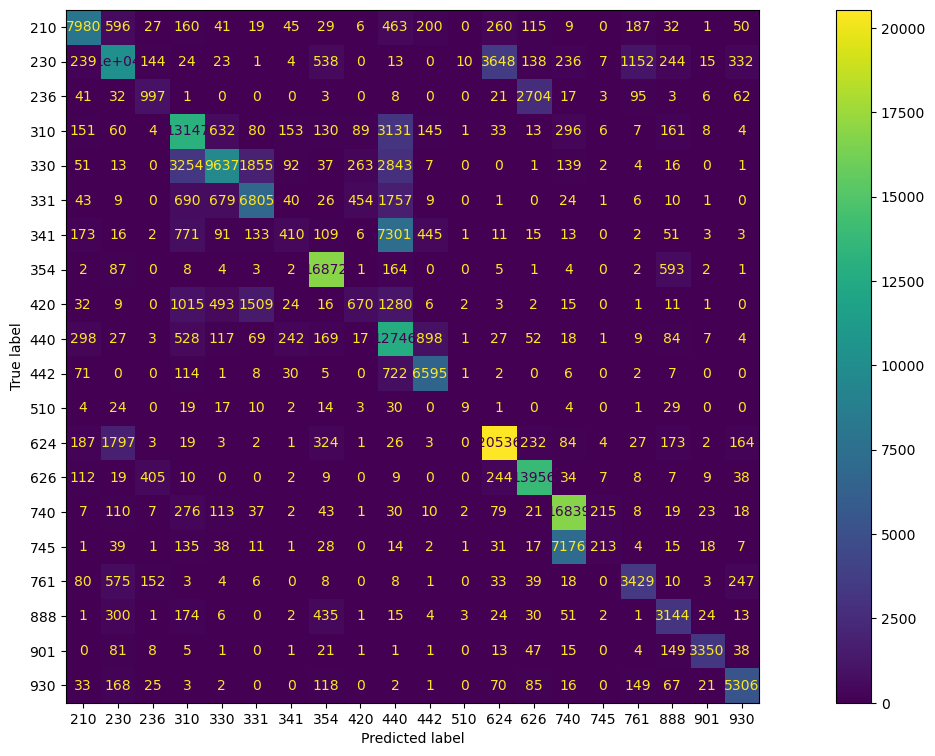

In [8]:

disp = ConfusionMatrixDisplay.from_predictions(
y_test, preds,
                  # labels=[1,0],
                  # cmap=plt.cm.Blues,
                  # display_labels=['Good','Bad'], 
                  # values_format='',  
) 
fig = disp.ax_.get_figure() 
fig.set_figwidth(20)
fig.set_figheight(9)  